In [1]:
import torch
import torchvision.models as models
import torch.cuda                   
from PIL import ImageFile
from torchvision import datasets
from torchvision.transforms import transforms
from base.model import ResNetRS
import copy
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.cuda                   
from typing import List, Callable, Tuple
from base.EMA import EMA
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [2]:
train_dir = 'D:/GP/LC25/train/'
valid_dir = 'D:/GP/LC25/val'
test_dir = 'D:/GP/LC25/test/'
train_set = train_dir
valid_set = valid_dir
test_set = test_dir
batch_size=16
shuffle=True
num_workers=1

transform = transforms.Compose([
    transforms.Resize((224,224)),   # 调整图像大小
    transforms.ToTensor(),  # 转换为PyTorch张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

train_data = datasets.ImageFolder(train_set, transform)
valid_data = datasets.ImageFolder(valid_set, transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

loaders = {
    'train': train_loader,
    'val': valid_loader
}

test_data = datasets.ImageFolder(test_set, transform=transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [3]:
print(len(train_data),len(valid_data),len(test_data))

2400 300 483


In [ ]:
ml=models.mobilenet_v2
model=ml.to(device)

In [ ]:
models.densenet._COMMON_META['categories']=3
den12=models.densenet121(weights=None)
model=den12.to(device)

In [ ]:
VGG16=models.mobilenet
model=VGG16.to(device)

In [ ]:
effic=models.efficientnet_v2_m(weights=None)
model=effic.to(device)

In [ ]:
mymodel=ResNetRS([3, 4, 6, 3], num_class=3)
model=mymodel.to(device)

In [4]:
models.resnet._COMMON_META['categories']=3
res=models.resnet50(weights=None)
model=res.to(device)

In [5]:
n_epochs         = 200
lr               = 0.001
model_name       = 'mymodel'
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
T_max = 40
eta_min = 1e-6
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
ema = EMA(model.parameters(), decay_rate=0.995, num_updates=0)

In [6]:
t_acc=[]
t_loss=[]
v_acc=[]
v_loss=[]

In [7]:
def train_model(model: nn.Module, criterion: Callable, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler, loaders: List[DataLoader], num_epochs: int = 10
               ) -> Tuple[nn.Module, List[float], List[float]]:  
    """
    Train a model on a dataset.

    Args:
      model: The model to train.
      criterion: The loss function.
      optimizer: The optimizer.
      scheduler: The learning_rate scheduler
      loaders: The training dataloader.
      num_epochs: The number of epochs to train for.

    Returns:
      A list of three elements. The first element is the model, the second element is a list of training losses, and the third element is a list of validation losses.
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience = 200
    counter = 0
    train_loss = []
    valid_loss = []
    
    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
                     
        # Training Phase
        model.train()
        running_corrects_T = 0
        running_loss_T = 0.0
        ns_T = 0
        train_dl = loaders['train']
        
        with tqdm(train_dl, desc=f"Training Epoch {epoch+1}") as pbar:

            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outp = model(images)
                _, pred = torch.max(outp, 1)
                loss = criterion(outp, labels)

                loss.backward()
                optimizer.step()
                ema.update(model.parameters())

                running_loss_T += loss.item() * images.size(0)
                running_corrects_T += torch.sum(pred == labels.data)
                ns_T += pred.shape[0]
                
                acc_value = running_corrects_T.double() / ns_T
                loss_value = running_loss_T/ ns_T
                metrics = {"Batch":f"Batch_{ns_T}","Train Accuracy":f"{acc_value:.3f}",
                           "Train Loss":f"{loss_value:.3f}"}
                pbar.set_postfix(metrics)
                
        # Validation Phase
        model.eval()

        ns_V = 0
        running_corrects_V = 0
        running_loss_V = 0.0
        valid_dl = loaders['val']
        
        with torch.no_grad():
            with tqdm(valid_dl, desc=f"Validation Epoch {epoch+1}") as pbar:

                for images, labels in pbar:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    ema.store(model.parameters())
                    ema.copy(model.parameters())

                    outp = model(images)
                    _, pred = torch.max(outp, 1)
                    val_loss = criterion(outp, labels)
                    ema.copy_back(model.parameters())

                    running_loss_V += val_loss.item() * images.size(0)
                    ns_V += pred.shape[0]
                    running_corrects_V += torch.sum(pred == labels.data)

                    acc_value = running_corrects_V.double() / ns_V
                    loss_value = running_loss_V/ ns_V

                    metrics = {"Val Accuracy":f"{acc_value:.3f}","Val Loss":f"{loss_value:.3f}"}
                    pbar.set_postfix(metrics)
                
        Train_loss = running_loss_T / len(train_dl.dataset)
        train_loss.append(Train_loss)
        Valid_loss = running_loss_V / len(valid_dl.dataset)
        valid_loss.append(Valid_loss)
        Train_acc = running_corrects_T.double() / ns_T
        Valid_acc = running_corrects_V.double() / ns_V
        
        scheduler.step()
        t_loss.append(Train_loss)
        t_acc.append(Train_acc)
        v_loss.append(Valid_loss)
        v_acc.append(Valid_acc)

        print(f'Train Loss: {Train_loss:.4f} Train Acc: {Train_acc:.4f} Valid Loss: {Valid_loss:.4f} Valid Acc: {Valid_acc:.4f}')
    
        if Valid_acc > best_acc and epoch >20:
            best_acc = Valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break
            
            
    print('Best accuracy {}'.format(best_acc))            
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss

In [ ]:
# n_epochs         = 200
# model_name       = 'mymodel'
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# T_max = 20
# eta_min = 1e-6
# exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [8]:
print(len(t_acc),len(t_loss),len(v_acc),len(v_loss))

0 0 0 0


In [9]:
new_model, train_loss, valid_loss = train_model(model, criterion, optimizer, exp_lr_scheduler, loaders, n_epochs)

Epoch 0/199
----------


Validation Epoch 1: 100%|██████████| 19/19 [00:03<00:00,  5.13it/s, Val Accuracy=0.887, Val Loss=0.274]


Train Loss: 0.7619 Train Acc: 0.6963 Valid Loss: 0.2738 Valid Acc: 0.8867
Epoch 1/199
----------


Validation Epoch 2: 100%|██████████| 19/19 [00:03<00:00,  5.00it/s, Val Accuracy=0.883, Val Loss=0.270]


Train Loss: 0.3846 Train Acc: 0.8363 Valid Loss: 0.2699 Valid Acc: 0.8833
Epoch 2/199
----------


Validation Epoch 3: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s, Val Accuracy=0.930, Val Loss=0.187]


Train Loss: 0.3124 Train Acc: 0.8754 Valid Loss: 0.1869 Valid Acc: 0.9300
Epoch 3/199
----------


Validation Epoch 4: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s, Val Accuracy=0.820, Val Loss=0.370]


Train Loss: 0.3103 Train Acc: 0.8733 Valid Loss: 0.3699 Valid Acc: 0.8200
Epoch 4/199
----------


Validation Epoch 5: 100%|██████████| 19/19 [00:03<00:00,  4.91it/s, Val Accuracy=0.870, Val Loss=0.291]


Train Loss: 0.2591 Train Acc: 0.9008 Valid Loss: 0.2911 Valid Acc: 0.8700
Epoch 5/199
----------


Validation Epoch 6: 100%|██████████| 19/19 [00:03<00:00,  4.89it/s, Val Accuracy=0.947, Val Loss=0.187]


Train Loss: 0.2528 Train Acc: 0.9033 Valid Loss: 0.1870 Valid Acc: 0.9467
Epoch 6/199
----------


Validation Epoch 7: 100%|██████████| 19/19 [00:03<00:00,  4.94it/s, Val Accuracy=0.930, Val Loss=0.179]


Train Loss: 0.2743 Train Acc: 0.8883 Valid Loss: 0.1793 Valid Acc: 0.9300
Epoch 7/199
----------


Validation Epoch 8: 100%|██████████| 19/19 [00:03<00:00,  5.06it/s, Val Accuracy=0.947, Val Loss=0.114]


Train Loss: 0.2393 Train Acc: 0.9025 Valid Loss: 0.1144 Valid Acc: 0.9467
Epoch 8/199
----------


Validation Epoch 9: 100%|██████████| 19/19 [00:03<00:00,  5.04it/s, Val Accuracy=0.877, Val Loss=0.307]


Train Loss: 0.2378 Train Acc: 0.9100 Valid Loss: 0.3067 Valid Acc: 0.8767
Epoch 9/199
----------


Validation Epoch 10: 100%|██████████| 19/19 [00:03<00:00,  4.93it/s, Val Accuracy=0.870, Val Loss=0.286]


Train Loss: 0.1814 Train Acc: 0.9296 Valid Loss: 0.2860 Valid Acc: 0.8700
Epoch 10/199
----------


Validation Epoch 11: 100%|██████████| 19/19 [00:03<00:00,  4.90it/s, Val Accuracy=0.907, Val Loss=0.220]


Train Loss: 0.1518 Train Acc: 0.9425 Valid Loss: 0.2201 Valid Acc: 0.9067
Epoch 11/199
----------


Validation Epoch 12: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s, Val Accuracy=0.890, Val Loss=0.214]


Train Loss: 0.2238 Train Acc: 0.9146 Valid Loss: 0.2144 Valid Acc: 0.8900
Epoch 12/199
----------


Validation Epoch 13: 100%|██████████| 19/19 [00:03<00:00,  4.85it/s, Val Accuracy=0.927, Val Loss=0.188]


Train Loss: 0.1846 Train Acc: 0.9317 Valid Loss: 0.1881 Valid Acc: 0.9267
Epoch 13/199
----------


Validation Epoch 14: 100%|██████████| 19/19 [00:03<00:00,  4.80it/s, Val Accuracy=0.973, Val Loss=0.068]


Train Loss: 0.2064 Train Acc: 0.9313 Valid Loss: 0.0675 Valid Acc: 0.9733
Epoch 14/199
----------


Validation Epoch 15: 100%|██████████| 19/19 [00:04<00:00,  4.72it/s, Val Accuracy=0.967, Val Loss=0.085]


Train Loss: 0.1292 Train Acc: 0.9567 Valid Loss: 0.0850 Valid Acc: 0.9667
Epoch 15/199
----------


Validation Epoch 16: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s, Val Accuracy=0.930, Val Loss=0.157]


Train Loss: 0.1576 Train Acc: 0.9500 Valid Loss: 0.1569 Valid Acc: 0.9300
Epoch 16/199
----------


Validation Epoch 17: 100%|██████████| 19/19 [00:04<00:00,  4.62it/s, Val Accuracy=0.960, Val Loss=0.083]


Train Loss: 0.1013 Train Acc: 0.9583 Valid Loss: 0.0827 Valid Acc: 0.9600
Epoch 17/199
----------


Validation Epoch 18: 100%|██████████| 19/19 [00:03<00:00,  4.95it/s, Val Accuracy=0.980, Val Loss=0.052]


Train Loss: 0.0805 Train Acc: 0.9663 Valid Loss: 0.0522 Valid Acc: 0.9800
Epoch 18/199
----------


Validation Epoch 19: 100%|██████████| 19/19 [00:03<00:00,  4.92it/s, Val Accuracy=0.950, Val Loss=0.130]


Train Loss: 0.0773 Train Acc: 0.9738 Valid Loss: 0.1298 Valid Acc: 0.9500
Epoch 19/199
----------


Validation Epoch 20: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s, Val Accuracy=0.953, Val Loss=0.122]


Train Loss: 0.0820 Train Acc: 0.9758 Valid Loss: 0.1220 Valid Acc: 0.9533
Epoch 20/199
----------


Validation Epoch 21: 100%|██████████| 19/19 [00:03<00:00,  4.90it/s, Val Accuracy=0.977, Val Loss=0.059]


Train Loss: 0.0644 Train Acc: 0.9733 Valid Loss: 0.0585 Valid Acc: 0.9767
Epoch 21/199
----------


Validation Epoch 22: 100%|██████████| 19/19 [00:03<00:00,  4.97it/s, Val Accuracy=0.970, Val Loss=0.083]


Train Loss: 0.0508 Train Acc: 0.9796 Valid Loss: 0.0830 Valid Acc: 0.9700
Epoch 22/199
----------


Validation Epoch 23: 100%|██████████| 19/19 [00:03<00:00,  4.91it/s, Val Accuracy=0.977, Val Loss=0.047]


Train Loss: 0.0656 Train Acc: 0.9804 Valid Loss: 0.0473 Valid Acc: 0.9767
Epoch 23/199
----------


Validation Epoch 24: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, Val Accuracy=0.977, Val Loss=0.074]


Train Loss: 0.0697 Train Acc: 0.9788 Valid Loss: 0.0740 Valid Acc: 0.9767
Epoch 24/199
----------


Validation Epoch 25: 100%|██████████| 19/19 [00:03<00:00,  4.96it/s, Val Accuracy=0.973, Val Loss=0.053]


Train Loss: 0.0476 Train Acc: 0.9842 Valid Loss: 0.0535 Valid Acc: 0.9733
Epoch 25/199
----------


Validation Epoch 26: 100%|██████████| 19/19 [00:03<00:00,  4.94it/s, Val Accuracy=0.983, Val Loss=0.038]


Train Loss: 0.0277 Train Acc: 0.9913 Valid Loss: 0.0378 Valid Acc: 0.9833
Epoch 26/199
----------


Validation Epoch 27: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, Val Accuracy=0.983, Val Loss=0.037]


Train Loss: 0.0264 Train Acc: 0.9925 Valid Loss: 0.0369 Valid Acc: 0.9833
Epoch 27/199
----------


Validation Epoch 28: 100%|██████████| 19/19 [00:03<00:00,  4.85it/s, Val Accuracy=0.980, Val Loss=0.035]


Train Loss: 0.0215 Train Acc: 0.9938 Valid Loss: 0.0351 Valid Acc: 0.9800
Epoch 28/199
----------


Validation Epoch 29: 100%|██████████| 19/19 [00:03<00:00,  5.03it/s, Val Accuracy=0.983, Val Loss=0.033]


Train Loss: 0.0157 Train Acc: 0.9963 Valid Loss: 0.0327 Valid Acc: 0.9833
Epoch 29/199
----------


Validation Epoch 30: 100%|██████████| 19/19 [00:03<00:00,  4.85it/s, Val Accuracy=0.990, Val Loss=0.029]


Train Loss: 0.0192 Train Acc: 0.9938 Valid Loss: 0.0289 Valid Acc: 0.9900
Epoch 30/199
----------


Validation Epoch 31: 100%|██████████| 19/19 [00:03<00:00,  4.85it/s, Val Accuracy=0.980, Val Loss=0.032]


Train Loss: 0.0212 Train Acc: 0.9925 Valid Loss: 0.0325 Valid Acc: 0.9800
Epoch 31/199
----------


Validation Epoch 32: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s, Val Accuracy=0.977, Val Loss=0.040]


Train Loss: 0.0131 Train Acc: 0.9967 Valid Loss: 0.0400 Valid Acc: 0.9767
Epoch 32/199
----------


Validation Epoch 33: 100%|██████████| 19/19 [00:03<00:00,  5.00it/s, Val Accuracy=0.977, Val Loss=0.062]


Train Loss: 0.0462 Train Acc: 0.9904 Valid Loss: 0.0617 Valid Acc: 0.9767
Epoch 33/199
----------


Validation Epoch 34: 100%|██████████| 19/19 [00:03<00:00,  4.92it/s, Val Accuracy=0.983, Val Loss=0.041]


Train Loss: 0.0187 Train Acc: 0.9950 Valid Loss: 0.0406 Valid Acc: 0.9833
Epoch 34/199
----------


Validation Epoch 35: 100%|██████████| 19/19 [00:03<00:00,  4.85it/s, Val Accuracy=0.983, Val Loss=0.036]


Train Loss: 0.0168 Train Acc: 0.9958 Valid Loss: 0.0357 Valid Acc: 0.9833
Epoch 35/199
----------


Validation Epoch 36: 100%|██████████| 19/19 [00:04<00:00,  4.45it/s, Val Accuracy=0.983, Val Loss=0.039]


Train Loss: 0.0116 Train Acc: 0.9983 Valid Loss: 0.0395 Valid Acc: 0.9833
Epoch 36/199
----------


Validation Epoch 37: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, Val Accuracy=0.977, Val Loss=0.047]


Train Loss: 0.0117 Train Acc: 0.9979 Valid Loss: 0.0470 Valid Acc: 0.9767
Epoch 37/199
----------


Validation Epoch 38: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, Val Accuracy=0.980, Val Loss=0.034]


Train Loss: 0.0141 Train Acc: 0.9967 Valid Loss: 0.0345 Valid Acc: 0.9800
Epoch 38/199
----------


Validation Epoch 39: 100%|██████████| 19/19 [00:04<00:00,  4.31it/s, Val Accuracy=0.980, Val Loss=0.036]


Train Loss: 0.0165 Train Acc: 0.9950 Valid Loss: 0.0356 Valid Acc: 0.9800
Epoch 39/199
----------


Validation Epoch 40: 100%|██████████| 19/19 [00:04<00:00,  4.51it/s, Val Accuracy=0.977, Val Loss=0.035]


Train Loss: 0.0155 Train Acc: 0.9954 Valid Loss: 0.0350 Valid Acc: 0.9767
Epoch 40/199
----------


Validation Epoch 41: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s, Val Accuracy=0.983, Val Loss=0.032]


Train Loss: 0.0163 Train Acc: 0.9942 Valid Loss: 0.0319 Valid Acc: 0.9833
Epoch 41/199
----------


Validation Epoch 42: 100%|██████████| 19/19 [00:04<00:00,  4.55it/s, Val Accuracy=0.983, Val Loss=0.038]


Train Loss: 0.0100 Train Acc: 0.9996 Valid Loss: 0.0383 Valid Acc: 0.9833
Epoch 42/199
----------


Validation Epoch 43: 100%|██████████| 19/19 [00:04<00:00,  4.55it/s, Val Accuracy=0.980, Val Loss=0.034]


Train Loss: 0.0113 Train Acc: 0.9975 Valid Loss: 0.0338 Valid Acc: 0.9800
Epoch 43/199
----------


Validation Epoch 44: 100%|██████████| 19/19 [00:04<00:00,  4.43it/s, Val Accuracy=0.987, Val Loss=0.031]


Train Loss: 0.0102 Train Acc: 0.9971 Valid Loss: 0.0314 Valid Acc: 0.9867
Epoch 44/199
----------


Validation Epoch 45: 100%|██████████| 19/19 [00:04<00:00,  4.06it/s, Val Accuracy=0.977, Val Loss=0.036]


Train Loss: 0.0142 Train Acc: 0.9950 Valid Loss: 0.0364 Valid Acc: 0.9767
Epoch 45/199
----------


Validation Epoch 46: 100%|██████████| 19/19 [00:04<00:00,  4.21it/s, Val Accuracy=0.980, Val Loss=0.036]


Train Loss: 0.0204 Train Acc: 0.9933 Valid Loss: 0.0363 Valid Acc: 0.9800
Epoch 46/199
----------


Validation Epoch 47: 100%|██████████| 19/19 [00:04<00:00,  4.49it/s, Val Accuracy=0.977, Val Loss=0.051]


Train Loss: 0.0372 Train Acc: 0.9888 Valid Loss: 0.0514 Valid Acc: 0.9767
Epoch 47/199
----------


Validation Epoch 48: 100%|██████████| 19/19 [00:04<00:00,  4.16it/s, Val Accuracy=0.977, Val Loss=0.039]


Train Loss: 0.0154 Train Acc: 0.9950 Valid Loss: 0.0394 Valid Acc: 0.9767
Epoch 48/199
----------


Validation Epoch 49: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s, Val Accuracy=0.993, Val Loss=0.032]


Train Loss: 0.0198 Train Acc: 0.9942 Valid Loss: 0.0315 Valid Acc: 0.9933
Epoch 49/199
----------


Validation Epoch 50: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s, Val Accuracy=0.980, Val Loss=0.047]


Train Loss: 0.0174 Train Acc: 0.9950 Valid Loss: 0.0466 Valid Acc: 0.9800
Epoch 50/199
----------


Validation Epoch 51: 100%|██████████| 19/19 [00:04<00:00,  4.28it/s, Val Accuracy=0.983, Val Loss=0.036]


Train Loss: 0.0161 Train Acc: 0.9954 Valid Loss: 0.0362 Valid Acc: 0.9833
Epoch 51/199
----------


Validation Epoch 52: 100%|██████████| 19/19 [00:04<00:00,  4.45it/s, Val Accuracy=0.983, Val Loss=0.039]


Train Loss: 0.0488 Train Acc: 0.9917 Valid Loss: 0.0387 Valid Acc: 0.9833
Epoch 52/199
----------


Validation Epoch 53: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, Val Accuracy=0.983, Val Loss=0.029]


Train Loss: 0.0205 Train Acc: 0.9933 Valid Loss: 0.0294 Valid Acc: 0.9833
Epoch 53/199
----------


Validation Epoch 54: 100%|██████████| 19/19 [00:04<00:00,  4.49it/s, Val Accuracy=0.977, Val Loss=0.041]


Train Loss: 0.0179 Train Acc: 0.9958 Valid Loss: 0.0415 Valid Acc: 0.9767
Epoch 54/199
----------


Validation Epoch 55: 100%|██████████| 19/19 [00:04<00:00,  4.48it/s, Val Accuracy=0.977, Val Loss=0.052]


Train Loss: 0.0202 Train Acc: 0.9950 Valid Loss: 0.0518 Valid Acc: 0.9767
Epoch 55/199
----------


Validation Epoch 56: 100%|██████████| 19/19 [00:04<00:00,  4.51it/s, Val Accuracy=0.977, Val Loss=0.045]


Train Loss: 0.0163 Train Acc: 0.9958 Valid Loss: 0.0445 Valid Acc: 0.9767
Epoch 56/199
----------


Validation Epoch 57: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s, Val Accuracy=0.970, Val Loss=0.090]


Train Loss: 0.0159 Train Acc: 0.9946 Valid Loss: 0.0901 Valid Acc: 0.9700
Epoch 57/199
----------


Validation Epoch 58: 100%|██████████| 19/19 [00:04<00:00,  4.52it/s, Val Accuracy=0.977, Val Loss=0.048]


Train Loss: 0.0142 Train Acc: 0.9958 Valid Loss: 0.0478 Valid Acc: 0.9767
Epoch 58/199
----------


Validation Epoch 59: 100%|██████████| 19/19 [00:04<00:00,  4.54it/s, Val Accuracy=0.980, Val Loss=0.061]


Train Loss: 0.0241 Train Acc: 0.9917 Valid Loss: 0.0612 Valid Acc: 0.9800
Epoch 59/199
----------


Validation Epoch 60: 100%|██████████| 19/19 [00:04<00:00,  4.54it/s, Val Accuracy=0.973, Val Loss=0.057]


Train Loss: 0.0401 Train Acc: 0.9892 Valid Loss: 0.0570 Valid Acc: 0.9733
Epoch 60/199
----------


Validation Epoch 61: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s, Val Accuracy=0.980, Val Loss=0.075]


Train Loss: 0.0866 Train Acc: 0.9763 Valid Loss: 0.0748 Valid Acc: 0.9800
Epoch 61/199
----------


Validation Epoch 62: 100%|██████████| 19/19 [00:04<00:00,  4.48it/s, Val Accuracy=0.977, Val Loss=0.046]


Train Loss: 0.0322 Train Acc: 0.9888 Valid Loss: 0.0456 Valid Acc: 0.9767
Epoch 62/199
----------


Validation Epoch 63: 100%|██████████| 19/19 [00:04<00:00,  4.50it/s, Val Accuracy=0.987, Val Loss=0.053]


Train Loss: 0.0477 Train Acc: 0.9817 Valid Loss: 0.0531 Valid Acc: 0.9867
Epoch 63/199
----------


Validation Epoch 64: 100%|██████████| 19/19 [00:04<00:00,  4.44it/s, Val Accuracy=0.987, Val Loss=0.093]


Train Loss: 0.0472 Train Acc: 0.9829 Valid Loss: 0.0927 Valid Acc: 0.9867
Epoch 64/199
----------


Validation Epoch 65: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s, Val Accuracy=0.963, Val Loss=0.112]


Train Loss: 0.0444 Train Acc: 0.9838 Valid Loss: 0.1124 Valid Acc: 0.9633
Epoch 65/199
----------


Validation Epoch 66: 100%|██████████| 19/19 [00:04<00:00,  4.53it/s, Val Accuracy=0.980, Val Loss=0.060]


Train Loss: 0.0440 Train Acc: 0.9850 Valid Loss: 0.0600 Valid Acc: 0.9800
Epoch 66/199
----------


Validation Epoch 67: 100%|██████████| 19/19 [00:04<00:00,  4.43it/s, Val Accuracy=0.980, Val Loss=0.064]


Train Loss: 0.0378 Train Acc: 0.9892 Valid Loss: 0.0639 Valid Acc: 0.9800
Epoch 67/199
----------


Validation Epoch 68: 100%|██████████| 19/19 [00:04<00:00,  4.52it/s, Val Accuracy=0.950, Val Loss=0.234]


Train Loss: 0.0400 Train Acc: 0.9833 Valid Loss: 0.2337 Valid Acc: 0.9500
Epoch 68/199
----------


Validation Epoch 69: 100%|██████████| 19/19 [00:04<00:00,  4.43it/s, Val Accuracy=0.963, Val Loss=0.101]


Train Loss: 0.0730 Train Acc: 0.9758 Valid Loss: 0.1007 Valid Acc: 0.9633
Epoch 69/199
----------


Validation Epoch 70: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s, Val Accuracy=0.960, Val Loss=0.111]


Train Loss: 0.0497 Train Acc: 0.9817 Valid Loss: 0.1109 Valid Acc: 0.9600
Epoch 70/199
----------


Validation Epoch 71: 100%|██████████| 19/19 [00:04<00:00,  4.53it/s, Val Accuracy=0.940, Val Loss=0.132]


Train Loss: 0.0871 Train Acc: 0.9654 Valid Loss: 0.1324 Valid Acc: 0.9400
Epoch 71/199
----------


Validation Epoch 72: 100%|██████████| 19/19 [00:04<00:00,  4.53it/s, Val Accuracy=0.973, Val Loss=0.060]


Train Loss: 0.0587 Train Acc: 0.9796 Valid Loss: 0.0601 Valid Acc: 0.9733
Epoch 72/199
----------


Validation Epoch 73: 100%|██████████| 19/19 [00:04<00:00,  4.29it/s, Val Accuracy=0.960, Val Loss=0.086]


Train Loss: 0.0471 Train Acc: 0.9821 Valid Loss: 0.0864 Valid Acc: 0.9600
Epoch 73/199
----------


Validation Epoch 74: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s, Val Accuracy=0.933, Val Loss=0.192]


Train Loss: 0.0757 Train Acc: 0.9721 Valid Loss: 0.1915 Valid Acc: 0.9333
Epoch 74/199
----------


Validation Epoch 75: 100%|██████████| 19/19 [00:04<00:00,  4.50it/s, Val Accuracy=0.980, Val Loss=0.052]


Train Loss: 0.0506 Train Acc: 0.9829 Valid Loss: 0.0519 Valid Acc: 0.9800
Epoch 75/199
----------


Validation Epoch 76: 100%|██████████| 19/19 [00:04<00:00,  4.47it/s, Val Accuracy=0.967, Val Loss=0.109]


Train Loss: 0.0353 Train Acc: 0.9863 Valid Loss: 0.1095 Valid Acc: 0.9667
Epoch 76/199
----------


Validation Epoch 77: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s, Val Accuracy=0.983, Val Loss=0.059]


Train Loss: 0.0482 Train Acc: 0.9833 Valid Loss: 0.0586 Valid Acc: 0.9833
Epoch 77/199
----------


Validation Epoch 78: 100%|██████████| 19/19 [00:04<00:00,  4.57it/s, Val Accuracy=0.980, Val Loss=0.048]


Train Loss: 0.0620 Train Acc: 0.9850 Valid Loss: 0.0482 Valid Acc: 0.9800
Epoch 78/199
----------


Validation Epoch 79: 100%|██████████| 19/19 [00:04<00:00,  4.55it/s, Val Accuracy=0.843, Val Loss=0.510]


Train Loss: 0.0353 Train Acc: 0.9888 Valid Loss: 0.5100 Valid Acc: 0.8433
Epoch 79/199
----------


Validation Epoch 80: 100%|██████████| 19/19 [00:04<00:00,  4.58it/s, Val Accuracy=0.980, Val Loss=0.054]


Train Loss: 0.0597 Train Acc: 0.9783 Valid Loss: 0.0535 Valid Acc: 0.9800
Epoch 80/199
----------


Validation Epoch 81: 100%|██████████| 19/19 [00:04<00:00,  4.66it/s, Val Accuracy=0.970, Val Loss=0.072]


Train Loss: 0.0251 Train Acc: 0.9913 Valid Loss: 0.0718 Valid Acc: 0.9700
Epoch 81/199
----------


Validation Epoch 82: 100%|██████████| 19/19 [00:04<00:00,  4.44it/s, Val Accuracy=0.987, Val Loss=0.028]


Train Loss: 0.0157 Train Acc: 0.9950 Valid Loss: 0.0279 Valid Acc: 0.9867
Epoch 82/199
----------


Validation Epoch 83: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, Val Accuracy=0.963, Val Loss=0.093]


Train Loss: 0.0277 Train Acc: 0.9896 Valid Loss: 0.0927 Valid Acc: 0.9633
Epoch 83/199
----------


Validation Epoch 84: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s, Val Accuracy=0.977, Val Loss=0.062]


Train Loss: 0.0093 Train Acc: 0.9975 Valid Loss: 0.0623 Valid Acc: 0.9767
Epoch 84/199
----------


Validation Epoch 85: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s, Val Accuracy=0.943, Val Loss=0.176]


Train Loss: 0.0452 Train Acc: 0.9913 Valid Loss: 0.1760 Valid Acc: 0.9433
Epoch 85/199
----------


Validation Epoch 86: 100%|██████████| 19/19 [00:04<00:00,  4.45it/s, Val Accuracy=0.933, Val Loss=0.217]


Train Loss: 0.0292 Train Acc: 0.9904 Valid Loss: 0.2168 Valid Acc: 0.9333
Epoch 86/199
----------


Validation Epoch 87: 100%|██████████| 19/19 [00:04<00:00,  4.63it/s, Val Accuracy=0.980, Val Loss=0.083]


Train Loss: 0.0291 Train Acc: 0.9908 Valid Loss: 0.0829 Valid Acc: 0.9800
Epoch 87/199
----------


Validation Epoch 88: 100%|██████████| 19/19 [00:03<00:00,  4.80it/s, Val Accuracy=0.983, Val Loss=0.088]


Train Loss: 0.0103 Train Acc: 0.9958 Valid Loss: 0.0882 Valid Acc: 0.9833
Epoch 88/199
----------


Validation Epoch 89: 100%|██████████| 19/19 [00:04<00:00,  4.23it/s, Val Accuracy=0.983, Val Loss=0.055]


Train Loss: 0.0089 Train Acc: 0.9963 Valid Loss: 0.0553 Valid Acc: 0.9833
Epoch 89/199
----------


Validation Epoch 90: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, Val Accuracy=0.977, Val Loss=0.064]


Train Loss: 0.0084 Train Acc: 0.9983 Valid Loss: 0.0641 Valid Acc: 0.9767
Epoch 90/199
----------


Validation Epoch 91: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s, Val Accuracy=0.990, Val Loss=0.037]


Train Loss: 0.0139 Train Acc: 0.9958 Valid Loss: 0.0365 Valid Acc: 0.9900
Epoch 91/199
----------


Validation Epoch 92: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s, Val Accuracy=0.983, Val Loss=0.060]


Train Loss: 0.0172 Train Acc: 0.9929 Valid Loss: 0.0597 Valid Acc: 0.9833
Epoch 92/199
----------


Validation Epoch 93: 100%|██████████| 19/19 [00:04<00:00,  4.50it/s, Val Accuracy=0.980, Val Loss=0.081]


Train Loss: 0.0179 Train Acc: 0.9950 Valid Loss: 0.0808 Valid Acc: 0.9800
Epoch 93/199
----------


Validation Epoch 94: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s, Val Accuracy=0.990, Val Loss=0.062]


Train Loss: 0.0094 Train Acc: 0.9975 Valid Loss: 0.0623 Valid Acc: 0.9900
Epoch 94/199
----------


Validation Epoch 95: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s, Val Accuracy=0.970, Val Loss=0.062]


Train Loss: 0.0120 Train Acc: 0.9954 Valid Loss: 0.0616 Valid Acc: 0.9700
Epoch 95/199
----------


Validation Epoch 96: 100%|██████████| 19/19 [00:04<00:00,  4.39it/s, Val Accuracy=0.980, Val Loss=0.058]


Train Loss: 0.0039 Train Acc: 0.9988 Valid Loss: 0.0580 Valid Acc: 0.9800
Epoch 96/199
----------


Validation Epoch 97: 100%|██████████| 19/19 [00:04<00:00,  4.21it/s, Val Accuracy=0.980, Val Loss=0.063]


Train Loss: 0.0033 Train Acc: 0.9996 Valid Loss: 0.0625 Valid Acc: 0.9800
Epoch 97/199
----------


Validation Epoch 98: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, Val Accuracy=0.980, Val Loss=0.061]


Train Loss: 0.0018 Train Acc: 1.0000 Valid Loss: 0.0606 Valid Acc: 0.9800
Epoch 98/199
----------


Validation Epoch 99: 100%|██████████| 19/19 [00:04<00:00,  4.21it/s, Val Accuracy=0.980, Val Loss=0.058]


Train Loss: 0.0026 Train Acc: 0.9996 Valid Loss: 0.0581 Valid Acc: 0.9800
Epoch 99/199
----------


Validation Epoch 100: 100%|██████████| 19/19 [00:03<00:00,  4.95it/s, Val Accuracy=0.983, Val Loss=0.055]


Train Loss: 0.0021 Train Acc: 0.9996 Valid Loss: 0.0553 Valid Acc: 0.9833
Epoch 100/199
----------


Validation Epoch 101: 100%|██████████| 19/19 [00:04<00:00,  4.66it/s, Val Accuracy=0.980, Val Loss=0.060]


Train Loss: 0.0016 Train Acc: 1.0000 Valid Loss: 0.0604 Valid Acc: 0.9800
Epoch 101/199
----------


Validation Epoch 102: 100%|██████████| 19/19 [00:03<00:00,  4.99it/s, Val Accuracy=0.980, Val Loss=0.068]


Train Loss: 0.0073 Train Acc: 0.9988 Valid Loss: 0.0682 Valid Acc: 0.9800
Epoch 102/199
----------


Validation Epoch 103: 100%|██████████| 19/19 [00:03<00:00,  4.89it/s, Val Accuracy=0.980, Val Loss=0.075]


Train Loss: 0.0052 Train Acc: 0.9983 Valid Loss: 0.0752 Valid Acc: 0.9800
Epoch 103/199
----------


Validation Epoch 104: 100%|██████████| 19/19 [00:03<00:00,  5.00it/s, Val Accuracy=0.983, Val Loss=0.080]


Train Loss: 0.0035 Train Acc: 0.9992 Valid Loss: 0.0801 Valid Acc: 0.9833
Epoch 104/199
----------


Validation Epoch 105: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s, Val Accuracy=0.983, Val Loss=0.085]


Train Loss: 0.0015 Train Acc: 0.9996 Valid Loss: 0.0853 Valid Acc: 0.9833
Epoch 105/199
----------


Validation Epoch 106: 100%|██████████| 19/19 [00:04<00:00,  4.62it/s, Val Accuracy=0.980, Val Loss=0.083]


Train Loss: 0.0022 Train Acc: 0.9992 Valid Loss: 0.0830 Valid Acc: 0.9800
Epoch 106/199
----------


Validation Epoch 107: 100%|██████████| 19/19 [00:04<00:00,  4.65it/s, Val Accuracy=0.983, Val Loss=0.095]


Train Loss: 0.0392 Train Acc: 0.9938 Valid Loss: 0.0952 Valid Acc: 0.9833
Epoch 107/199
----------


Validation Epoch 108: 100%|██████████| 19/19 [00:03<00:00,  4.82it/s, Val Accuracy=0.983, Val Loss=0.081]


Train Loss: 0.0022 Train Acc: 0.9996 Valid Loss: 0.0814 Valid Acc: 0.9833
Epoch 108/199
----------


Validation Epoch 109: 100%|██████████| 19/19 [00:03<00:00,  4.85it/s, Val Accuracy=0.980, Val Loss=0.076]


Train Loss: 0.0036 Train Acc: 0.9988 Valid Loss: 0.0757 Valid Acc: 0.9800
Epoch 109/199
----------


Validation Epoch 110: 100%|██████████| 19/19 [00:04<00:00,  4.58it/s, Val Accuracy=0.977, Val Loss=0.075]


Train Loss: 0.0011 Train Acc: 0.9996 Valid Loss: 0.0752 Valid Acc: 0.9767
Epoch 110/199
----------


Validation Epoch 111: 100%|██████████| 19/19 [00:03<00:00,  4.76it/s, Val Accuracy=0.977, Val Loss=0.080]


Train Loss: 0.0248 Train Acc: 0.9975 Valid Loss: 0.0804 Valid Acc: 0.9767
Epoch 111/199
----------


Validation Epoch 112: 100%|██████████| 19/19 [00:04<00:00,  4.50it/s, Val Accuracy=0.980, Val Loss=0.072]


Train Loss: 0.0040 Train Acc: 0.9988 Valid Loss: 0.0724 Valid Acc: 0.9800
Epoch 112/199
----------


Validation Epoch 113: 100%|██████████| 19/19 [00:04<00:00,  4.31it/s, Val Accuracy=0.977, Val Loss=0.076]


Train Loss: 0.0015 Train Acc: 0.9996 Valid Loss: 0.0763 Valid Acc: 0.9767
Epoch 113/199
----------


Validation Epoch 114: 100%|██████████| 19/19 [00:04<00:00,  4.60it/s, Val Accuracy=0.980, Val Loss=0.072]


Train Loss: 0.0116 Train Acc: 0.9975 Valid Loss: 0.0722 Valid Acc: 0.9800
Epoch 114/199
----------


Validation Epoch 115: 100%|██████████| 19/19 [00:03<00:00,  4.85it/s, Val Accuracy=0.977, Val Loss=0.076]


Train Loss: 0.0018 Train Acc: 0.9996 Valid Loss: 0.0764 Valid Acc: 0.9767
Epoch 115/199
----------


Validation Epoch 116: 100%|██████████| 19/19 [00:04<00:00,  4.45it/s, Val Accuracy=0.980, Val Loss=0.070]


Train Loss: 0.0114 Train Acc: 0.9979 Valid Loss: 0.0701 Valid Acc: 0.9800
Epoch 116/199
----------


Validation Epoch 117: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s, Val Accuracy=0.980, Val Loss=0.072]


Train Loss: 0.0349 Train Acc: 0.9954 Valid Loss: 0.0715 Valid Acc: 0.9800
Epoch 117/199
----------


Validation Epoch 118: 100%|██████████| 19/19 [00:04<00:00,  4.68it/s, Val Accuracy=0.977, Val Loss=0.071]


Train Loss: 0.0048 Train Acc: 0.9988 Valid Loss: 0.0713 Valid Acc: 0.9767
Epoch 118/199
----------


Validation Epoch 119: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s, Val Accuracy=0.977, Val Loss=0.075]


Train Loss: 0.0179 Train Acc: 0.9983 Valid Loss: 0.0750 Valid Acc: 0.9767
Epoch 119/199
----------


Validation Epoch 120: 100%|██████████| 19/19 [00:03<00:00,  4.84it/s, Val Accuracy=0.980, Val Loss=0.072]


Train Loss: 0.0029 Train Acc: 0.9992 Valid Loss: 0.0725 Valid Acc: 0.9800
Epoch 120/199
----------


Validation Epoch 121: 100%|██████████| 19/19 [00:03<00:00,  4.79it/s, Val Accuracy=0.980, Val Loss=0.068]


Train Loss: 0.0018 Train Acc: 0.9996 Valid Loss: 0.0680 Valid Acc: 0.9800
Epoch 121/199
----------


Validation Epoch 122: 100%|██████████| 19/19 [00:04<00:00,  4.63it/s, Val Accuracy=0.980, Val Loss=0.065]


Train Loss: 0.0022 Train Acc: 0.9996 Valid Loss: 0.0653 Valid Acc: 0.9800
Epoch 122/199
----------


Validation Epoch 123: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, Val Accuracy=0.980, Val Loss=0.068]


Train Loss: 0.0012 Train Acc: 1.0000 Valid Loss: 0.0679 Valid Acc: 0.9800
Epoch 123/199
----------


Validation Epoch 124: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, Val Accuracy=0.980, Val Loss=0.067]


Train Loss: 0.0061 Train Acc: 0.9983 Valid Loss: 0.0675 Valid Acc: 0.9800
Epoch 124/199
----------


Validation Epoch 125: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s, Val Accuracy=0.977, Val Loss=0.074]


Train Loss: 0.0143 Train Acc: 0.9983 Valid Loss: 0.0742 Valid Acc: 0.9767
Epoch 125/199
----------


Validation Epoch 126: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s, Val Accuracy=0.980, Val Loss=0.068]


Train Loss: 0.0010 Train Acc: 1.0000 Valid Loss: 0.0682 Valid Acc: 0.9800
Epoch 126/199
----------


Validation Epoch 127: 100%|██████████| 19/19 [00:04<00:00,  4.61it/s, Val Accuracy=0.983, Val Loss=0.072]


Train Loss: 0.0022 Train Acc: 0.9992 Valid Loss: 0.0722 Valid Acc: 0.9833
Epoch 127/199
----------


Validation Epoch 128: 100%|██████████| 19/19 [00:03<00:00,  4.88it/s, Val Accuracy=0.980, Val Loss=0.075]


Train Loss: 0.0019 Train Acc: 0.9996 Valid Loss: 0.0747 Valid Acc: 0.9800
Epoch 128/199
----------


Validation Epoch 129: 100%|██████████| 19/19 [00:04<00:00,  4.71it/s, Val Accuracy=0.977, Val Loss=0.078]


Train Loss: 0.0015 Train Acc: 1.0000 Valid Loss: 0.0781 Valid Acc: 0.9767
Epoch 129/199
----------


Validation Epoch 130: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s, Val Accuracy=0.980, Val Loss=0.073]


Train Loss: 0.0094 Train Acc: 0.9988 Valid Loss: 0.0729 Valid Acc: 0.9800
Epoch 130/199
----------


Validation Epoch 131: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, Val Accuracy=0.980, Val Loss=0.071]


Train Loss: 0.0015 Train Acc: 0.9996 Valid Loss: 0.0714 Valid Acc: 0.9800
Epoch 131/199
----------


Validation Epoch 132: 100%|██████████| 19/19 [00:04<00:00,  4.68it/s, Val Accuracy=0.980, Val Loss=0.075]


Train Loss: 0.0150 Train Acc: 0.9983 Valid Loss: 0.0750 Valid Acc: 0.9800
Epoch 132/199
----------


Validation Epoch 133: 100%|██████████| 19/19 [00:03<00:00,  4.84it/s, Val Accuracy=0.977, Val Loss=0.076]


Train Loss: 0.0119 Train Acc: 0.9971 Valid Loss: 0.0763 Valid Acc: 0.9767
Epoch 133/199
----------


Validation Epoch 134: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s, Val Accuracy=0.980, Val Loss=0.070]


Train Loss: 0.0022 Train Acc: 0.9996 Valid Loss: 0.0705 Valid Acc: 0.9800
Epoch 134/199
----------


Validation Epoch 135: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, Val Accuracy=0.977, Val Loss=0.076]


Train Loss: 0.0127 Train Acc: 0.9967 Valid Loss: 0.0757 Valid Acc: 0.9767
Epoch 135/199
----------


Validation Epoch 136: 100%|██████████| 19/19 [00:03<00:00,  4.79it/s, Val Accuracy=0.980, Val Loss=0.076]


Train Loss: 0.0024 Train Acc: 0.9996 Valid Loss: 0.0762 Valid Acc: 0.9800
Epoch 136/199
----------


Validation Epoch 137: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, Val Accuracy=0.977, Val Loss=0.082]


Train Loss: 0.0059 Train Acc: 0.9979 Valid Loss: 0.0821 Valid Acc: 0.9767
Epoch 137/199
----------


Validation Epoch 138: 100%|██████████| 19/19 [00:03<00:00,  4.76it/s, Val Accuracy=0.980, Val Loss=0.084]


Train Loss: 0.0048 Train Acc: 0.9979 Valid Loss: 0.0845 Valid Acc: 0.9800
Epoch 138/199
----------


Validation Epoch 139: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s, Val Accuracy=0.977, Val Loss=0.070]


Train Loss: 0.0063 Train Acc: 0.9988 Valid Loss: 0.0704 Valid Acc: 0.9767
Epoch 139/199
----------


Validation Epoch 140: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, Val Accuracy=0.980, Val Loss=0.067]


Train Loss: 0.0291 Train Acc: 0.9925 Valid Loss: 0.0671 Valid Acc: 0.9800
Epoch 140/199
----------


Validation Epoch 141: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, Val Accuracy=0.980, Val Loss=0.109]


Train Loss: 0.0031 Train Acc: 0.9988 Valid Loss: 0.1094 Valid Acc: 0.9800
Epoch 141/199
----------


Validation Epoch 142: 100%|██████████| 19/19 [00:03<00:00,  4.89it/s, Val Accuracy=0.987, Val Loss=0.102]


Train Loss: 0.0019 Train Acc: 0.9996 Valid Loss: 0.1023 Valid Acc: 0.9867
Epoch 142/199
----------


Validation Epoch 143: 100%|██████████| 19/19 [00:03<00:00,  4.79it/s, Val Accuracy=0.980, Val Loss=0.067]


Train Loss: 0.0013 Train Acc: 1.0000 Valid Loss: 0.0673 Valid Acc: 0.9800
Epoch 143/199
----------


Validation Epoch 144: 100%|██████████| 19/19 [00:03<00:00,  4.83it/s, Val Accuracy=0.970, Val Loss=0.071]


Train Loss: 0.0013 Train Acc: 0.9996 Valid Loss: 0.0712 Valid Acc: 0.9700
Epoch 144/199
----------


Validation Epoch 145: 100%|██████████| 19/19 [00:03<00:00,  4.78it/s, Val Accuracy=0.970, Val Loss=0.060]


Train Loss: 0.0012 Train Acc: 1.0000 Valid Loss: 0.0603 Valid Acc: 0.9700
Epoch 145/199
----------


Validation Epoch 146: 100%|██████████| 19/19 [00:04<00:00,  4.59it/s, Val Accuracy=0.980, Val Loss=0.060]


Train Loss: 0.0015 Train Acc: 0.9996 Valid Loss: 0.0601 Valid Acc: 0.9800
Epoch 146/199
----------


Validation Epoch 147: 100%|██████████| 19/19 [00:03<00:00,  4.76it/s, Val Accuracy=0.977, Val Loss=0.081]


Train Loss: 0.0049 Train Acc: 0.9979 Valid Loss: 0.0811 Valid Acc: 0.9767
Epoch 147/199
----------


Validation Epoch 148: 100%|██████████| 19/19 [00:04<00:00,  4.58it/s, Val Accuracy=0.987, Val Loss=0.056]


Train Loss: 0.0025 Train Acc: 0.9996 Valid Loss: 0.0558 Valid Acc: 0.9867
Epoch 148/199
----------


Validation Epoch 149: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s, Val Accuracy=0.970, Val Loss=0.105]


Train Loss: 0.0028 Train Acc: 0.9992 Valid Loss: 0.1048 Valid Acc: 0.9700
Epoch 149/199
----------


Validation Epoch 150: 100%|██████████| 19/19 [00:04<00:00,  4.67it/s, Val Accuracy=0.953, Val Loss=0.183]


Train Loss: 0.0374 Train Acc: 0.9938 Valid Loss: 0.1831 Valid Acc: 0.9533
Epoch 150/199
----------


Validation Epoch 151: 100%|██████████| 19/19 [00:04<00:00,  4.68it/s, Val Accuracy=0.930, Val Loss=0.312]


Train Loss: 0.0786 Train Acc: 0.9792 Valid Loss: 0.3124 Valid Acc: 0.9300
Epoch 151/199
----------


Validation Epoch 152: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s, Val Accuracy=0.957, Val Loss=0.148]


Train Loss: 0.0883 Train Acc: 0.9750 Valid Loss: 0.1482 Valid Acc: 0.9567
Epoch 152/199
----------


Validation Epoch 153: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s, Val Accuracy=0.977, Val Loss=0.084]


Train Loss: 0.0219 Train Acc: 0.9917 Valid Loss: 0.0839 Valid Acc: 0.9767
Epoch 153/199
----------


Validation Epoch 154: 100%|██████████| 19/19 [00:04<00:00,  4.72it/s, Val Accuracy=0.977, Val Loss=0.073]


Train Loss: 0.0060 Train Acc: 0.9979 Valid Loss: 0.0730 Valid Acc: 0.9767
Epoch 154/199
----------


Validation Epoch 155: 100%|██████████| 19/19 [00:04<00:00,  4.67it/s, Val Accuracy=0.980, Val Loss=0.055]


Train Loss: 0.0271 Train Acc: 0.9954 Valid Loss: 0.0551 Valid Acc: 0.9800
Epoch 155/199
----------


Validation Epoch 156: 100%|██████████| 19/19 [00:03<00:00,  4.84it/s, Val Accuracy=0.977, Val Loss=0.085]


Train Loss: 0.0065 Train Acc: 0.9979 Valid Loss: 0.0847 Valid Acc: 0.9767
Epoch 156/199
----------


Validation Epoch 157: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, Val Accuracy=0.980, Val Loss=0.104]


Train Loss: 0.0116 Train Acc: 0.9942 Valid Loss: 0.1040 Valid Acc: 0.9800
Epoch 157/199
----------


Validation Epoch 158: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s, Val Accuracy=0.967, Val Loss=0.084]


Train Loss: 0.0111 Train Acc: 0.9975 Valid Loss: 0.0843 Valid Acc: 0.9667
Epoch 158/199
----------


Validation Epoch 159: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, Val Accuracy=0.973, Val Loss=0.077]


Train Loss: 0.0077 Train Acc: 0.9979 Valid Loss: 0.0766 Valid Acc: 0.9733
Epoch 159/199
----------


Validation Epoch 160: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s, Val Accuracy=0.973, Val Loss=0.066]


Train Loss: 0.0194 Train Acc: 0.9971 Valid Loss: 0.0663 Valid Acc: 0.9733
Epoch 160/199
----------


Validation Epoch 161: 100%|██████████| 19/19 [00:03<00:00,  4.80it/s, Val Accuracy=0.953, Val Loss=0.204]


Train Loss: 0.0238 Train Acc: 0.9954 Valid Loss: 0.2042 Valid Acc: 0.9533
Epoch 161/199
----------


Validation Epoch 162: 100%|██████████| 19/19 [00:03<00:00,  4.78it/s, Val Accuracy=0.930, Val Loss=0.267]


Train Loss: 0.0240 Train Acc: 0.9946 Valid Loss: 0.2672 Valid Acc: 0.9300
Epoch 162/199
----------


Validation Epoch 163: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, Val Accuracy=0.957, Val Loss=0.218]


Train Loss: 0.0087 Train Acc: 0.9963 Valid Loss: 0.2178 Valid Acc: 0.9567
Epoch 163/199
----------


Validation Epoch 164: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s, Val Accuracy=0.977, Val Loss=0.070]


Train Loss: 0.0046 Train Acc: 0.9988 Valid Loss: 0.0696 Valid Acc: 0.9767
Epoch 164/199
----------


Validation Epoch 165: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, Val Accuracy=0.980, Val Loss=0.053]


Train Loss: 0.0029 Train Acc: 0.9992 Valid Loss: 0.0534 Valid Acc: 0.9800
Epoch 165/199
----------


Validation Epoch 166: 100%|██████████| 19/19 [00:03<00:00,  4.92it/s, Val Accuracy=0.983, Val Loss=0.039]


Train Loss: 0.0018 Train Acc: 0.9996 Valid Loss: 0.0395 Valid Acc: 0.9833
Epoch 166/199
----------


Validation Epoch 167: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s, Val Accuracy=0.980, Val Loss=0.051]


Train Loss: 0.0053 Train Acc: 0.9988 Valid Loss: 0.0509 Valid Acc: 0.9800
Epoch 167/199
----------


Validation Epoch 168: 100%|██████████| 19/19 [00:03<00:00,  4.83it/s, Val Accuracy=0.987, Val Loss=0.067]


Train Loss: 0.0049 Train Acc: 0.9983 Valid Loss: 0.0672 Valid Acc: 0.9867
Epoch 168/199
----------


Validation Epoch 169: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s, Val Accuracy=0.967, Val Loss=0.107]


Train Loss: 0.0128 Train Acc: 0.9950 Valid Loss: 0.1074 Valid Acc: 0.9667
Epoch 169/199
----------


Validation Epoch 170: 100%|██████████| 19/19 [00:03<00:00,  4.76it/s, Val Accuracy=0.977, Val Loss=0.071]


Train Loss: 0.0078 Train Acc: 0.9975 Valid Loss: 0.0708 Valid Acc: 0.9767
Epoch 170/199
----------


Validation Epoch 171: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s, Val Accuracy=0.983, Val Loss=0.071]


Train Loss: 0.0014 Train Acc: 0.9996 Valid Loss: 0.0712 Valid Acc: 0.9833
Epoch 171/199
----------


Validation Epoch 172: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s, Val Accuracy=0.977, Val Loss=0.080]


Train Loss: 0.0193 Train Acc: 0.9967 Valid Loss: 0.0797 Valid Acc: 0.9767
Epoch 172/199
----------


Validation Epoch 173: 100%|██████████| 19/19 [00:04<00:00,  4.64it/s, Val Accuracy=0.977, Val Loss=0.060]


Train Loss: 0.0206 Train Acc: 0.9958 Valid Loss: 0.0598 Valid Acc: 0.9767
Epoch 173/199
----------


Validation Epoch 174: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s, Val Accuracy=0.983, Val Loss=0.059]


Train Loss: 0.0027 Train Acc: 0.9988 Valid Loss: 0.0586 Valid Acc: 0.9833
Epoch 174/199
----------


Validation Epoch 175: 100%|██████████| 19/19 [00:04<00:00,  4.71it/s, Val Accuracy=0.983, Val Loss=0.054]


Train Loss: 0.0025 Train Acc: 0.9996 Valid Loss: 0.0536 Valid Acc: 0.9833
Epoch 175/199
----------


Validation Epoch 176: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s, Val Accuracy=0.983, Val Loss=0.051]


Train Loss: 0.0018 Train Acc: 0.9996 Valid Loss: 0.0512 Valid Acc: 0.9833
Epoch 176/199
----------


Validation Epoch 177: 100%|██████████| 19/19 [00:03<00:00,  4.88it/s, Val Accuracy=0.983, Val Loss=0.050]


Train Loss: 0.0017 Train Acc: 0.9996 Valid Loss: 0.0503 Valid Acc: 0.9833
Epoch 177/199
----------


Validation Epoch 178: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, Val Accuracy=0.973, Val Loss=0.068]


Train Loss: 0.0021 Train Acc: 0.9996 Valid Loss: 0.0679 Valid Acc: 0.9733
Epoch 178/199
----------


Validation Epoch 179: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s, Val Accuracy=0.980, Val Loss=0.051]


Train Loss: 0.0016 Train Acc: 0.9996 Valid Loss: 0.0509 Valid Acc: 0.9800
Epoch 179/199
----------


Validation Epoch 180: 100%|██████████| 19/19 [00:04<00:00,  4.57it/s, Val Accuracy=0.970, Val Loss=0.095]


Train Loss: 0.0112 Train Acc: 0.9983 Valid Loss: 0.0947 Valid Acc: 0.9700
Epoch 180/199
----------


Validation Epoch 181: 100%|██████████| 19/19 [00:04<00:00,  4.71it/s, Val Accuracy=0.980, Val Loss=0.046]


Train Loss: 0.0054 Train Acc: 0.9983 Valid Loss: 0.0464 Valid Acc: 0.9800
Epoch 181/199
----------


Validation Epoch 182: 100%|██████████| 19/19 [00:04<00:00,  4.72it/s, Val Accuracy=0.987, Val Loss=0.053]


Train Loss: 0.0009 Train Acc: 1.0000 Valid Loss: 0.0534 Valid Acc: 0.9867
Epoch 182/199
----------


Validation Epoch 183: 100%|██████████| 19/19 [00:03<00:00,  4.92it/s, Val Accuracy=0.983, Val Loss=0.051]


Train Loss: 0.0032 Train Acc: 0.9992 Valid Loss: 0.0509 Valid Acc: 0.9833
Epoch 183/199
----------


Validation Epoch 184: 100%|██████████| 19/19 [00:04<00:00,  4.53it/s, Val Accuracy=0.977, Val Loss=0.058]


Train Loss: 0.0016 Train Acc: 0.9996 Valid Loss: 0.0584 Valid Acc: 0.9767
Epoch 184/199
----------


Validation Epoch 185: 100%|██████████| 19/19 [00:03<00:00,  4.79it/s, Val Accuracy=0.977, Val Loss=0.051]


Train Loss: 0.0015 Train Acc: 0.9996 Valid Loss: 0.0507 Valid Acc: 0.9767
Epoch 185/199
----------


Validation Epoch 186: 100%|██████████| 19/19 [00:03<00:00,  4.90it/s, Val Accuracy=0.980, Val Loss=0.048]


Train Loss: 0.0005 Train Acc: 1.0000 Valid Loss: 0.0483 Valid Acc: 0.9800
Epoch 186/199
----------


Validation Epoch 187: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s, Val Accuracy=0.973, Val Loss=0.063]


Train Loss: 0.0007 Train Acc: 1.0000 Valid Loss: 0.0630 Valid Acc: 0.9733
Epoch 187/199
----------


Validation Epoch 188: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s, Val Accuracy=0.980, Val Loss=0.066]


Train Loss: 0.0007 Train Acc: 1.0000 Valid Loss: 0.0658 Valid Acc: 0.9800
Epoch 188/199
----------


Validation Epoch 189: 100%|██████████| 19/19 [00:03<00:00,  4.94it/s, Val Accuracy=0.980, Val Loss=0.060]


Train Loss: 0.0008 Train Acc: 1.0000 Valid Loss: 0.0604 Valid Acc: 0.9800
Epoch 189/199
----------


Validation Epoch 190: 100%|██████████| 19/19 [00:03<00:00,  4.91it/s, Val Accuracy=0.980, Val Loss=0.052]


Train Loss: 0.0007 Train Acc: 1.0000 Valid Loss: 0.0518 Valid Acc: 0.9800
Epoch 190/199
----------


Validation Epoch 191: 100%|██████████| 19/19 [00:03<00:00,  4.86it/s, Val Accuracy=0.980, Val Loss=0.057]


Train Loss: 0.0008 Train Acc: 0.9996 Valid Loss: 0.0571 Valid Acc: 0.9800
Epoch 191/199
----------


Validation Epoch 192: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s, Val Accuracy=0.980, Val Loss=0.051]


Train Loss: 0.0006 Train Acc: 1.0000 Valid Loss: 0.0506 Valid Acc: 0.9800
Epoch 192/199
----------


Validation Epoch 193: 100%|██████████| 19/19 [00:04<00:00,  4.72it/s, Val Accuracy=0.980, Val Loss=0.060]


Train Loss: 0.0012 Train Acc: 0.9996 Valid Loss: 0.0603 Valid Acc: 0.9800
Epoch 193/199
----------


Validation Epoch 194: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s, Val Accuracy=0.970, Val Loss=0.062]


Train Loss: 0.0004 Train Acc: 1.0000 Valid Loss: 0.0615 Valid Acc: 0.9700
Epoch 194/199
----------


Validation Epoch 195: 100%|██████████| 19/19 [00:04<00:00,  4.46it/s, Val Accuracy=0.980, Val Loss=0.056]


Train Loss: 0.0021 Train Acc: 0.9996 Valid Loss: 0.0562 Valid Acc: 0.9800
Epoch 195/199
----------


Validation Epoch 196: 100%|██████████| 19/19 [00:03<00:00,  4.77it/s, Val Accuracy=0.980, Val Loss=0.051]


Train Loss: 0.0005 Train Acc: 1.0000 Valid Loss: 0.0509 Valid Acc: 0.9800
Epoch 196/199
----------


Validation Epoch 197: 100%|██████████| 19/19 [00:04<00:00,  4.72it/s, Val Accuracy=0.980, Val Loss=0.056]


Train Loss: 0.0007 Train Acc: 1.0000 Valid Loss: 0.0555 Valid Acc: 0.9800
Epoch 197/199
----------


Validation Epoch 198: 100%|██████████| 19/19 [00:03<00:00,  4.80it/s, Val Accuracy=0.980, Val Loss=0.048]


Train Loss: 0.0007 Train Acc: 0.9996 Valid Loss: 0.0477 Valid Acc: 0.9800
Epoch 198/199
----------


Validation Epoch 199: 100%|██████████| 19/19 [00:03<00:00,  4.85it/s, Val Accuracy=0.980, Val Loss=0.054]


Train Loss: 0.0007 Train Acc: 0.9996 Valid Loss: 0.0536 Valid Acc: 0.9800
Epoch 199/199
----------


Validation Epoch 200: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, Val Accuracy=0.983, Val Loss=0.060]

Train Loss: 0.0002 Train Acc: 1.0000 Valid Loss: 0.0596 Valid Acc: 0.9833
Best accuracy 0.9933333333333334


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# 确保模型处于评估模式
model.eval()

# 收集预测结果
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [12]:
test_classes = ['aca', 'normal', 'scc']

Accuracy: 0.9710
Precision: 0.9718
Recall: 0.9710
F1 Score: 0.9710


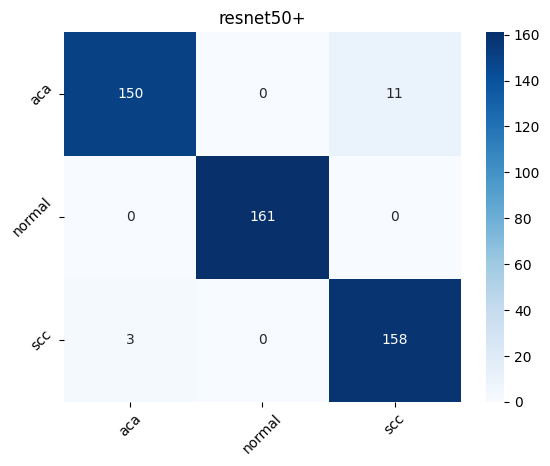

In [13]:
# test_classes = ['Bengin', 'Malignant', 'Normal']
# # 计算评价指标

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# 打印评价指标
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵
conf_mat = confusion_matrix(all_labels, all_preds)

# 可视化混淆矩阵
sns.heatmap(conf_mat, fmt='g', annot=True, cmap='Blues', xticklabels=test_classes, yticklabels=test_classes)
plt.title('resnet50+')
plt.xticks(rotation=45)  # 旋转x轴标签以便更容易阅读
plt.yticks(rotation=45)  # 旋转y轴标签以便更容易阅读
plt.show()

In [14]:
train_acc=[]
val_acc=[]
for i in range(len(t_acc)):
    train_acc.append(t_acc[i].cpu().numpy())
for i in range(len(v_acc)):
    val_acc.append(v_acc[i].cpu().numpy())

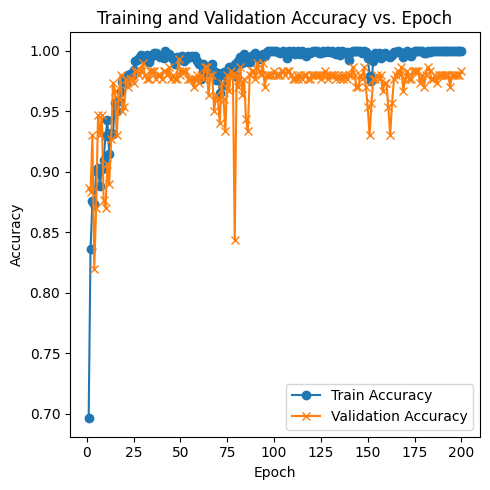

In [15]:
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(5, 5))
plt.plot(epochs, train_acc, marker='o', linestyle='-', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='x', linestyle='-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


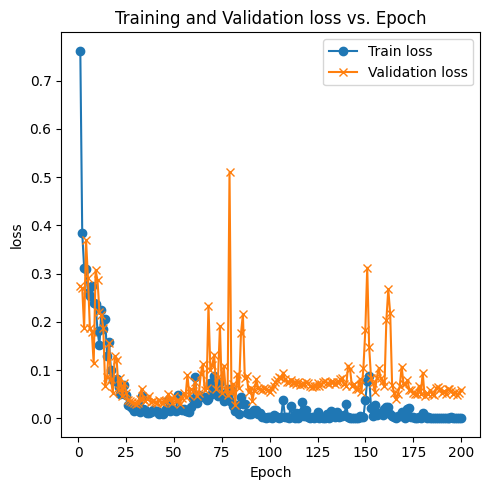

In [16]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(5, 5))
plt.plot(epochs, train_loss, marker='o', linestyle='-', label='Train loss')
plt.plot(epochs, valid_loss, marker='x', linestyle='-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss vs. Epoch')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()